# Trined Model Evalution

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/chest-x-ray-diagnosis'

In [2]:
# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from hydra import compose, initialize

from src.utils.utils import plot_auc_curve
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor
from src.weighted_loss.weighted_loss import get_weighted_loss

2025-03-20 11:55:16.359268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742471716.373045  138848 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742471716.377301  138848 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR)

datasets/sample/sample/images


In [4]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

In [5]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [6]:
CLASSES_NAME = ['Atelectasis','Effusion','Infiltration', 'Mass', 'No Finding']#,'Nodule']

## Loading Data

In [7]:
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor

test_prorcessor  = ChestXRayPreprocessor(cfg, labels=CLASSES_NAME)
_, test_ds, _, _, _= test_prorcessor.get_training_and_validation_datasets()


2025-03-20 11:55:20,864 — src.data_loader.chest_x_ray_preprocessor — INFO — Getting training and validation datasets with batch size:None
2025-03-20 11:55:20,865 — src.data_loader.chest_x_ray_preprocessor — INFO — Loading and preprocessing dataframe
2025-03-20 11:55:20,871 — src.data_loader.chest_x_ray_preprocessor — INFO — Cleaning up training dataframe
2025-03-20 11:55:20,897 — src.data_loader.chest_x_ray_preprocessor — INFO — Loaded dataframe with shape: (5606, 2) and 5606 rows
2025-03-20 11:55:20,916 — src.data_loader.chest_x_ray_preprocessor — INFO — training split: 3947 and validation split: 987


I0000 00:00:1742471720.844316  138848 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7422 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


2025-03-20 11:55:21,501 — src.data_loader.chest_x_ray_preprocessor — INFO — Normalization layer adapted
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-20 11:55:21,946 — src.data_loader.chest_x_ray_preprocessor — INFO — Normalizing image
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-20 11:55:23,063 — src.data_loader.chest_x_ray_preprocessor — INFO — Preparing training dataset with augmentation
2025

In [8]:
for batch in test_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(32, 512, 512, 3) (32, 5)
(512, 512, 3) -2.117904 2.64 tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


## Load the Trained model 

In [9]:
# tf_model = tf.keras.saving.load_model('exported_models/my_densenet/checkpoints/ckpt_32.keras')
# # tf_model.summary()
# y_pred = tf_model.predict(test_ds)
# y_pred = (y_pred > 0.5).astype(int)
# y_pred

In [10]:
import numpy as np


# test_dataset_np = np.array([np.array([x.astype(np.uint8), y.astype(int)]) for x, y in ])
# test_dataset_np

  # Ensure the dataset is shuffled (if it's not already)
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())

  # Take a batch of images and labels
test_images = []
y_true = []
for image, label in test_ds.unbatch().as_numpy_iterator():
    # for image, label in zip(images, labels):
    test_images.append(image.astype(np.uint8))
    y_true.append(label.astype(int))

y_true = np.array(y_true)
y_true[:5]

array([[1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [25]:
model_uri = 'runs:/47b17419d4bf472aad729af3f1db5636/my_model'
# The model is logged with an input example
mlflow_model =mlflow.tensorflow.load_model(model_uri)

In [26]:
y_pred_pyfunc = mlflow_model.predict(test_ds)
y_pred_pyfunc = (y_pred_pyfunc > 0.5).astype(int)
y_pred_pyfunc

31/31 [==============================] - 5s 75ms/step


array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0]])

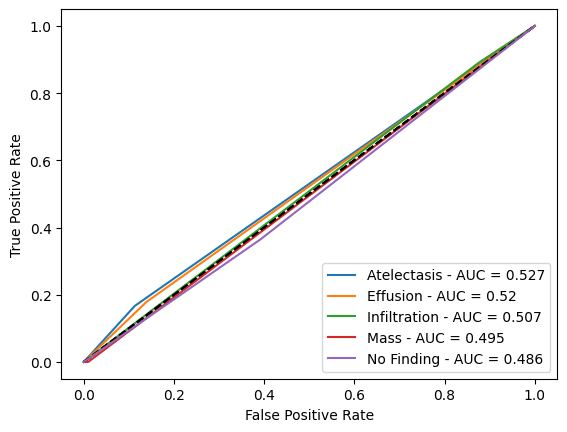

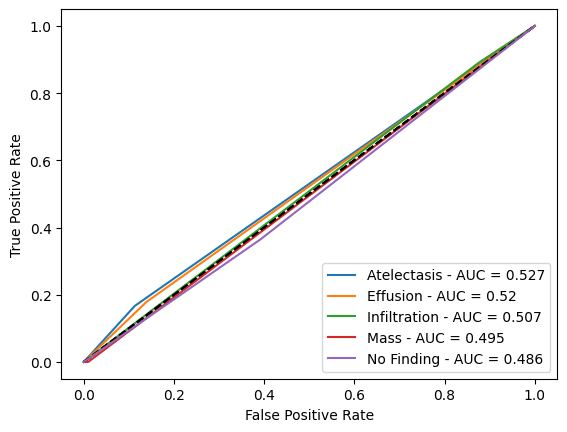

In [27]:
plot_auc_curve(output_dir='resources', 
               class_name_list=CLASSES_NAME, 
               y_true=y_true, 
               y_prob_pred=y_pred_pyfunc)

In [28]:
y_true

array([[1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])

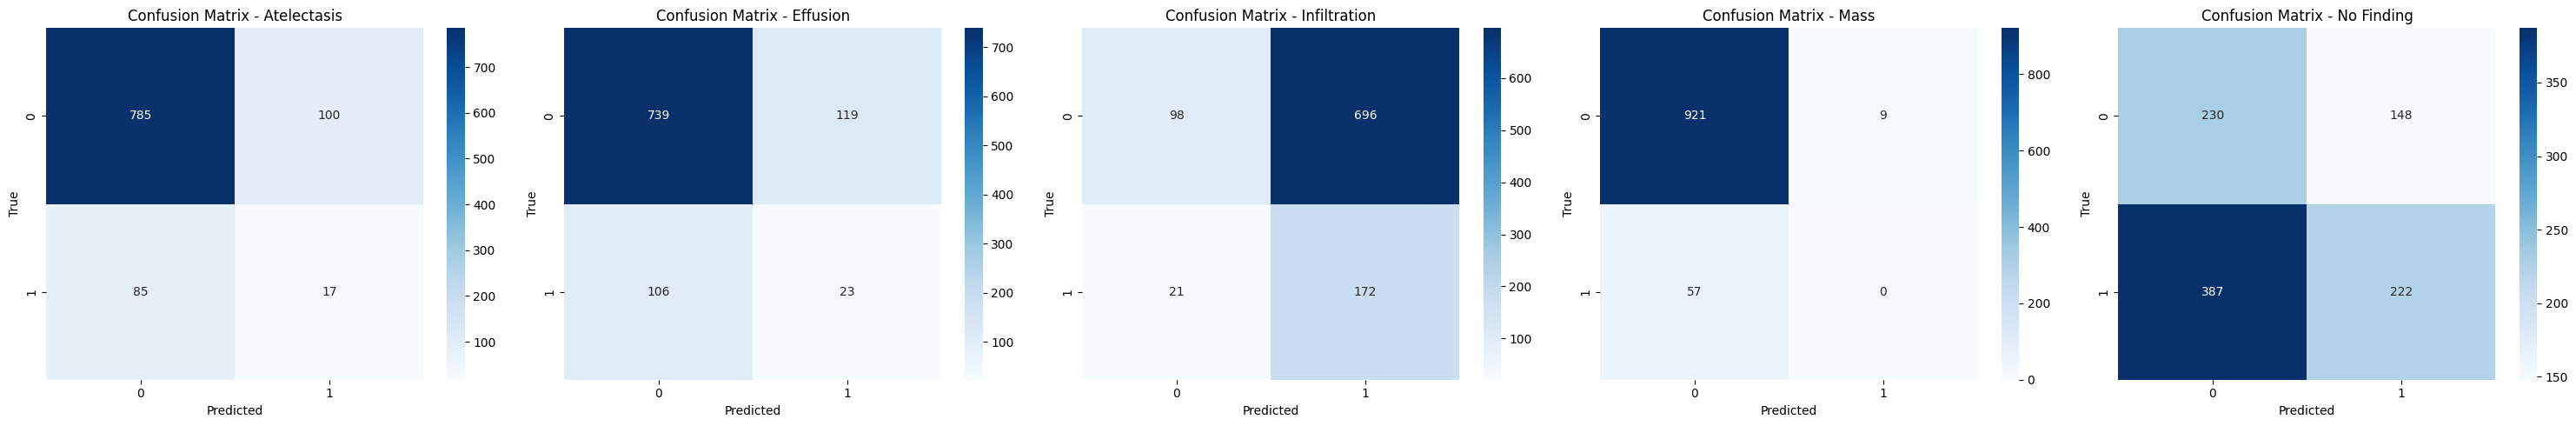

In [29]:
# Multi-label Confusion Matrix
from sklearn.metrics import confusion_matrix

num_classes = len(CLASSES_NAME)
fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 6, 5))
for i, class_label in enumerate(CLASSES_NAME):
    cm = confusion_matrix(y_true[:, i], y_pred_pyfunc[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - {class_label}')

plt.tight_layout()
plt.show()
# mlflow.log_figure(fig, 'confusion_matrices.png')
plt.close(fig)

In [30]:
def plot_random_images(test_images, test_labels, num_images=9):
  """
  Plots a random sample of images and their corresponding labels from a TensorFlow dataset.

  Args:
    train_ds: A TensorFlow dataset object containing image-label pairs.
    num_images: The number of images to plot (default: 9).
  """

  # Create a figure and axes for the plot
  plt.figure(figsize=(10, 10))

  # Iterate through the images and plot them
  for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1) # Create a grid of subplots
    plt.imshow(test_images[i], cmap='gray') # Convert to numpy and uint8 for display
    lab_np = test_labels[i]
    pred_indices = np.where(lab_np==1)[0]
    if len(pred_indices) == 0:
       class_names='None'
    else:
      class_names = '-'.join([CLASSES_NAME[i] for i in pred_indices])
    plt.title(f"{class_names}") # Display the label
    plt.axis("off") # Hide the axes

  plt.tight_layout()
  plt.show()

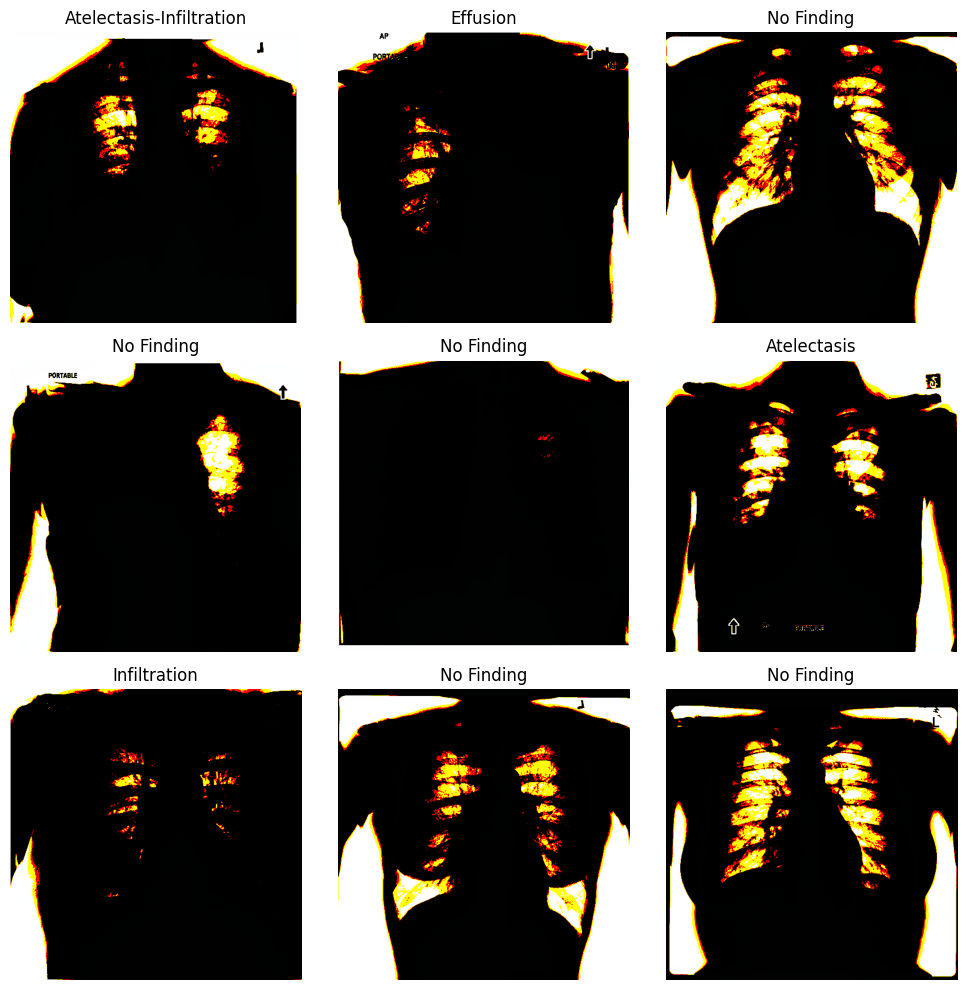

In [31]:
plot_random_images(test_images, y_true, num_images=9)

In [32]:
y_pred_pyfunc[0]

array([0, 0, 1, 0, 0])

[1 0 1 0 0]
[0 1 0 0 0]
[0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 0 1]
[1 0 0 0 0]
[0 0 1 0 0]
[0 0 0 0 1]


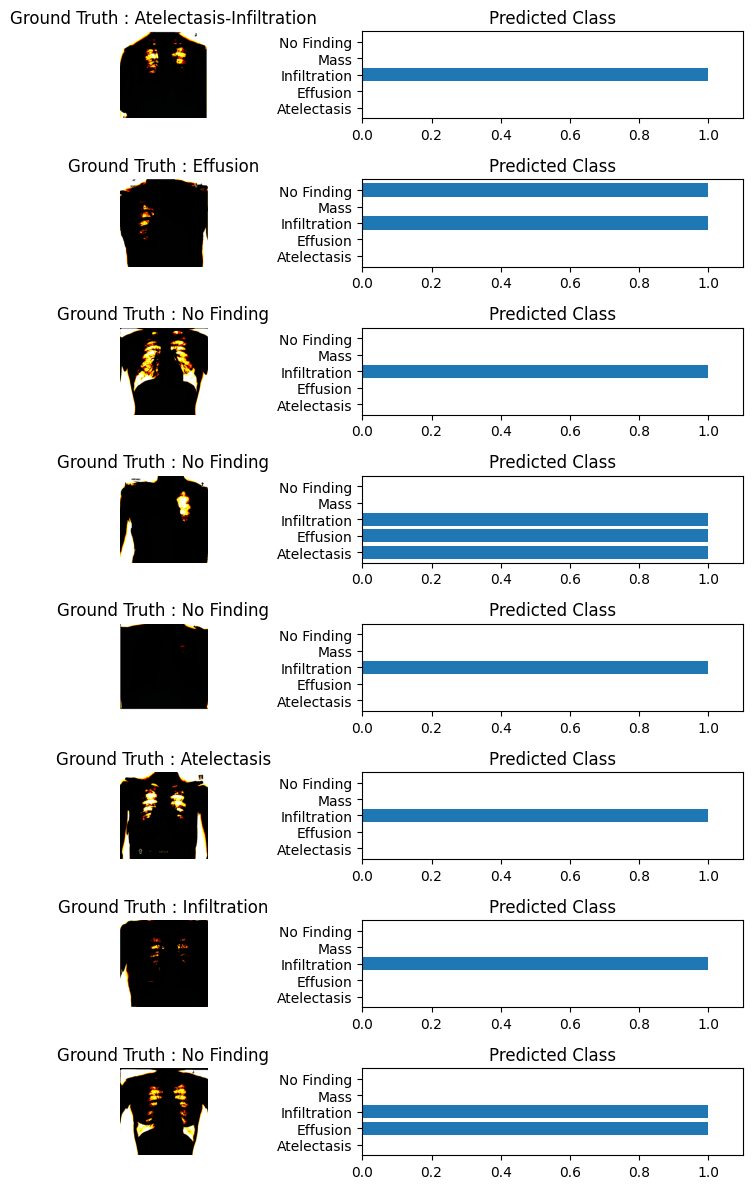

In [34]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=8)

for idx in range(8):
    test_image = test_images[idx]
    _y_true = y_true[idx]
    print(_y_true)
    y_pred = y_pred_pyfunc[idx]
    y_true_labels = np.where(_y_true==1)[0]
    y_true_class_name = [CLASSES_NAME[i] for i in y_true_labels]
    if len(y_true_labels) == 0:
        title = '-'
    else : 
        title = '-'.join(y_true_class_name)
    #idx = idx//2
    ax[idx,0].imshow(test_image)
    ax[idx,0].set_title('Ground Truth : {}'.format(title))
    ax[idx,0].axis('off')
    ax[idx,1].barh(CLASSES_NAME, y_pred)
    ax[idx,1].set_yticks(CLASSES_NAME)
    ax[idx,1].set_yticklabels(CLASSES_NAME)
    ax[idx,1].set_title('Predicted Class')
    ax[idx,1].set_xlim(0, 1.1)

plt.tight_layout()
plt.show()